In [1]:
import os
import numpy as np
import sys
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import pandas as pd
import cv2 
from tqdm import tqdm_notebook as tqdm
from IPython.display import Video, HTML
import ipyvolume as ipv
from scipy.interpolate import interpn, RegularGridInterpolator
from multiprocessing import Pool

In [7]:
folder_data = "./data/"
folder_nano = os.path.join(folder_data, "./nano/")
filename_train_metadata = os.path.join(folder_data, "train_metadata.csv")
filename_train_labels = os.path.join(folder_data, "train_labels.csv")

names_nano = [f.name for f in os.scandir(folder_nano)]

data_train_metadata = pd.read_csv(filename_train_metadata)
data_train_labels = pd.read_csv(filename_train_labels)

folder_test = "/media/igorkozlovskii/Elements/Projects/stall_catchers/test/"
names_test = [f.name for f in os.scandir(folder_test)]

Number of frames: 30


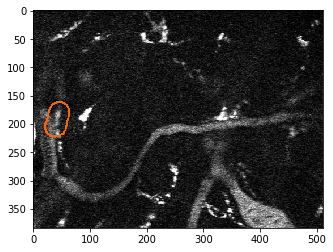

(384, 512, 3)


In [3]:
name_0 = "171621.mp4"
filename_0 = os.path.join(folder_nano, name_0)
vid = imageio.read(filename_0)
num = vid.count_frames()
print("Number of frames:", num)
frame_img = vid.get_data(0)
plt.imshow(frame_img)
plt.show()

print(frame_img.shape)

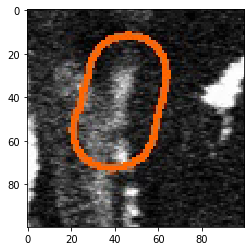

In [4]:
sub = frame_img[150:250, :100, :]
plt.imshow(sub)
plt.show()

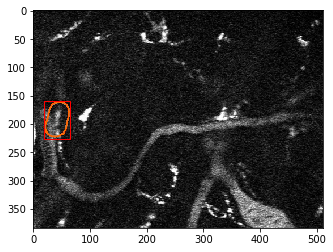

In [5]:
vid = cv2.VideoCapture(filename_0)
v_len = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
ret, frame = vid.read()
th = cv2.inRange(frame, (9, 13, 104), (98, 143, 255))                                                                                                                
points = np.where(th>0)                                                                                                                                              
p2 = zip(points[0], points[1])                                                                                                                                       
p2 = [p for p in p2]                                                                                                                                                 
rect = cv2.boundingRect(np.float32(p2))                                                                                                                              
# cv2.rectangle(th, (rect[1], rect[0]), (rect[1]+rect[3], rect[0]+rect[2]), 255)                                                                                       
# cv2.imshow("t", th)

fig, ax = plt.subplots()
ax.imshow(frame_img)
rect = mpl.patches.Rectangle((rect[1],rect[0]),rect[3],rect[2],
                             linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [6]:
# BORDER_COLOR_1 = (9, 13, 104)
# BORDER_COLOR_2 = (98, 143, 255)
BORDER_COLOR_1 = (104, 9, 13)
BORDER_COLOR_2 = (255, 143, 98)

def read_video_frames(filename):
    video = cv2.VideoCapture(filename)
    frames = []
    for i in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        _, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return np.array(frames)

# def get_border(image, border_color_1=BORDER_COLOR_1, border_color_2=BORDER_COLOR_2):
#     border_mask = cv2.inRange(image, border_color_1, border_color_2)
#     border_points = np.where(border_mask>0)
#     border_points = np.array([[border_points[0][i], border_points[1][i]] 
#                               for i in range(len(border_points[0]))])
#     return border_points

def get_border(image, color_diff=20):
    image_mean = image.mean(axis=-1)
    diff = np.max(np.abs([
        image[:, :, 0]-image_mean,
        image[:, :, 1]-image_mean,
        image[:, :, 2]-image_mean,]), axis=0)
    border_indexes = np.where(diff > color_diff)
    return border_indexes


def get_bounding_box(image, *args, **kwargs):
#     border_points = get_border(image, *args, **kwargs)
#     rect = np.array(cv2.boundingRect(border_points))
#     rect[2] += rect[0]
#     rect[3] += rect[1]
    border_indexes = get_border(image, *args, **kwargs)
    rect = np.zeros((4), np.int32)
    rect[0] = np.min(border_indexes[0])
    rect[1] = np.min(border_indexes[1])
    rect[2] = np.max(border_indexes[0])
    rect[3] = np.max(border_indexes[1])
    return rect

def crop_image_rect(image, rect=None, add=0):
    if rect is None:
        rect = np.array([0, 0, image.shape[0], image.shape[1]])
    rect[0] = max(rect[0]-add, 0)
    rect[1] = max(rect[1]-add, 0)
    rect[2] = min(rect[2]+add, image.shape[0])
    rect[3] = min(rect[3]+add, image.shape[1])
    return image[rect[0]:rect[2], rect[1]:rect[3]]

# def crop_image(image, border_color_1=BORDER_COLOR_1, border_color_2=BORDER_COLOR_2, add=0):
#     rect = get_bounding_box(image, border_color_1=border_color_1, border_color_2=border_color_2)
#     image = crop_image_rect(image, rect, add=add)
#     return image
def crop_image(image, add=0, **kwargs):
    rect = get_bounding_box(image, **kwargs)
    image = crop_image_rect(image, rect, add=add)
    return image

# def crop_video(video, border_color_1=BORDER_COLOR_1, border_color_2=BORDER_COLOR_2, add=0):
#     rect_list = [get_bounding_box(image, border_color_1=border_color_1, border_color_2=border_color_2)
#                 for image in video]
def crop_video(video, add=0, **kwargs):
    rect_list = [get_bounding_box(image, **kwargs) for image in video]
    rect_list = np.array(rect_list)
    rect = np.zeros((4), np.int32)
    rect[0] = rect_list[:, 0].max()
    rect[1] = rect_list[:, 1].max()
    rect[2] = rect_list[:, 2].min()
    rect[3] = rect_list[:, 3].min()
    video = [crop_image_rect(image, rect, add=add) for image in video]
    return np.array(video)

def show_video_frame(filename, index=0):
    video = read_video_frames(filename)
    frame = video[index]
    plt.imshow(frame)
    plt.show()
    return

def show_video(video, interval=20):
    fig, ax = plt.subplots()
    im = ax.imshow(video[0])
    def init():
        im.set_data(video[0])
        return (im,)
    def animate(i):
        im.set_data(video[i])
        return (im,)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(video), interval=interval, blit=True)
    mpl.rc('animation', html='html5')
    HTML(anim.to_html5_video())
    return anim

# def get_mask_indexes(image_size, border_points):
#     indexes = [[], []]
#     border_points = border_points.tolist()
# #     print(border_points)
#     for i in range(image_size[0]):
#         in_border = False
#         is_border = False
#         for j in range(image_size[1]):
#             if [i, j] in border_points:
#                 if not is_border:
#                     in_border = not in_border
#                 is_border = True
#                 indexes[0].append(i)
#                 indexes[1].append(j)
#             elif not in_border:
#                 indexes[0].append(i)
#                 indexes[1].append(j)
#                 is_border = False
#     return indexes

# def mask_image(image, color_diff=20, border_size=3):
#     for i in range(image.shape[0]):
#         in_border = False
#         is_border = 0
#         for j in range(image.shape[1]):
#             r = image[i, j]
#             m = r.mean()
#             if np.any(np.abs(r - m) > color_diff):
# #                 if not is_border:
# #                     in_border = not in_border
#                 is_border += 1
#                 image[i, j] = [0, 0, 0]
#             else:
#                 if is_border >= border_size:
#                     in_border = not in_border
#                 if not in_border:
#                     image[i, j] = [0, 0, 0]
#                 is_border = 0
#     return image

def get_mask(image, color_diff=20):
    border_indexes = get_border(image, color_diff=color_diff)
    border_points = [[border_indexes[0][i], border_indexes[1][i]] 
        for i in range(len(border_indexes[0]))]
    indexes_0 = []
    for i in range(image.shape[0]):
        ind = np.where(border_indexes[0] == i)[0]
        if len(ind) == 0:
            indexes_0.append([])
        else:
            indexes_0.append([
                np.min(border_indexes[1][ind]),
                np.max(border_indexes[1][ind]),
            ])
            
    indexes_1 = []
    for i in range(image.shape[1]):
        ind = np.where(border_indexes[1] == i)[0]
        if len(ind) == 0:
            indexes_1.append([])
        else:
            indexes_1.append([
                np.min(border_indexes[0][ind]),
                np.max(border_indexes[0][ind]),
            ])
    mask = np.ones((image.shape[0], image.shape[1]), np.bool)
    mask[border_indexes] = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if [i, j] in border_indexes:
                continue
            if j <= indexes_0[i][0] or j >= indexes_0[i][1] or \
                i <= indexes_1[j][0] or i >= indexes_1[j][1]:
                mask[i, j] = 0
    return mask

def mask_image(image, mask):
    image[:, :, 0] *= mask
    image[:, :, 1] *= mask
    image[:, :, 2] *= mask
    return image
        
def mask_image_in_border(image, *args, **kwargs):
    mask = get_mask(image, *args, **kwargs)
    image = np.copy(image)
    mask_image(image, mask)
    return image

# def mask_image_in_border(image, border_color_1=BORDER_COLOR_1, border_color_2=BORDER_COLOR_2):
# #     bounding_box = get_bounding_box(image, 
# #         border_color_1=border_color_1, border_color_2=border_color_2)
# #     image_cropped = crop_image(image, bounding_box)
#     border_points = get_border(image, 
#         border_color_1=border_color_1, border_color_2=border_color_2)
#     image[get_mask_indexes(image.shape[:2], border_points)] = [0, 0, 0]
#     return image

def mask_video_in_border(video, *args, **kwargs):
#     return np.array([mask_image_in_border(image, *args, **kwargs) for image in video])
    mask = get_mask(video[0], *args, **kwargs)
    for i in range(len(video)):
        mask_image(video[i], mask)
    return video

def convert_image_to_occupancy(image):
    return np.array(image.mean(axis=-1) / 255, np.float32)
def convert_video_to_occupancy(video):
    return np.array(video.mean(axis=-1) / 255, np.float32)

def crop_volume(volume):
    rect_list = []
    for i in range(len(volume)):
        mask_ind = np.where(volume[i] > 0)
        rect = np.zeros((4), np.int32)
        rect[0] = np.min(mask_ind[0])
        rect[1] = np.min(mask_ind[1])
        rect[2] = np.max(mask_ind[0])
        rect[3] = np.max(mask_ind[1])
        rect_list.append(rect)
    rect_list = np.array(rect_list)
    rect = np.zeros((4), np.int32)
    rect[0] = np.min(rect_list[:, 0])
    rect[1] = np.min(rect_list[:, 1])
    rect[2] = np.max(rect_list[:, 2])
    rect[3] = np.max(rect_list[:, 3])
    return volume[:, rect[0]:rect[2], rect[1]:rect[3]]

def interpolate_volume(volume, shape, method="linear"):
    ind1 = np.arange(volume.shape[0])
    ind2 = np.arange(volume.shape[1])
    ind3 = np.arange(volume.shape[2])
    fn = RegularGridInterpolator((ind1, ind2, ind3), volume, 
        method=method, bounds_error=False, fill_value=0)
    sh1 = np.linspace(0, volume.shape[0], shape[0])
    sh2 = np.linspace(0, volume.shape[1], shape[1])
    sh3 = np.linspace(0, volume.shape[2], shape[2])
    indexes, coords = [], []
    for i, c1 in enumerate(sh1):
        for j, c2 in enumerate(sh2):
            for k, c3 in enumerate(sh3):
                indexes.append([i, j, k])
                coords.append([c1, c2, c3])
    result = np.empty(shape, np.float32)
#     res = fn(coords)
#     print(len(res), 64*64*64)
    result = np.reshape(fn(coords), shape)
#     sh1 = np.linspace(0, shape[0], volume.shape[0])
#     sh2 = np.linspace(0, shape[1], volume.shape[1])
#     sh3 = np.linspace(0, shape[2], volume.shape[2])
#     fn = RegularGridInterpolator((sh1, sh2, sh3), volume, **kwargs)
    
    return result

def save_video_to_volume(filename_in, filename_out, shape=(32, 32, 32)):
    video = read_video_frames(filename_in)
    video = crop_video(video)
    video = mask_video_in_border(video)
    volume = convert_video_to_occupancy(video)
    volume = crop_volume(volume)
    volume = interpolate_volume(volume, shape)
    np.save(filename_out, volume)
    return volume

def save_video_to_volume_p(args):
    return save_video_to_volume(*args)

def save_list(names, folder_in, folder_out, shape=(32, 32, 32), threads=8):
    def get_args():
        for name in names:
            filename = os.path.join(folder_in, name)
            filename_out = os.path.join(folder_out, name.split(".")[0] + ".npy")
            yield filename, filename_out, shape
    progress = tqdm(total=len(names))
    if threads == 1:
        for arg in get_args():
            save_video_to_volume(*arg)
            progress.update()
    else:
        pool = Pool(processes=threads)
        for _ in pool.imap_unordered(save_video_to_volume_p, get_args()):
            progress.update()
        pool.close()
        pool.join()
    progress.close()
    return

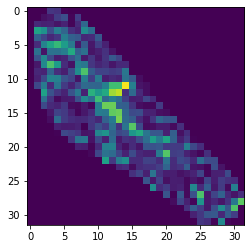

In [7]:
# filename = os.path.join(folder_nano, names_nano[6])
# filename = os.path.join(folder_nano, names_nano_stall[-10])
# filename = "./data/./nano/223214.mp4"
# video = read_video_frames(filename)
# video = crop_video(video)
# video = mask_video_in_border(video)
show_video(volume, interval=30)
# plt.imshow(video[-1])
# plt.show()

In [8]:
# volume = convert_video_to_occupancy(video)
# volume = crop_volume(volume)
# # volume = interpolate_volume(volume, (64, 64, 64))
# volume = interpolate_volume(volume, (32, 32, 32))
volume = np.load("../res/data/micro_numpy/100109.npy")
print(volume.shape, volume.min(), volume.max(), volume.mean())
ipv.figure()
ipv.volshow(volume, level=[0.5, 0.9], opacity=0.1, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()

(32, 32, 32) 0.0 0.99998313 0.09137767


/usr/local/lib/python3.6/dist-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [65]:
video_shapes = []
video_stats = []
for name in tqdm(names_nano):
    filename = os.path.join(folder_nano, name)
    video = read_video_frames(filename)
    video = crop_video(video)
    video = mask_video_in_border(video)
    volume = convert_video_to_occupancy(video)
    volume = crop_volume(volume)
    video_shapes.append(volume.shape)
    video_stats.append([video.min(), video.max(), video.mean(), video.std()])

/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [121]:
memory_volumes = [v[0] * v[1] * v[2] * 4 / 1024 / 1024 for v in video_shapes]
print(sum(memory_volumes) / 1024)

memory_volumes_fixed = 64 * 64 * 64 * 4 * 1400 / 1024 / 1024
print(memory_volumes_fixed / 1024)

1.4611840955913067
1.3671875


z 24 185 62.20523708421798
x 23 245 57.66525123849964
y 17 365 59.903750884642605


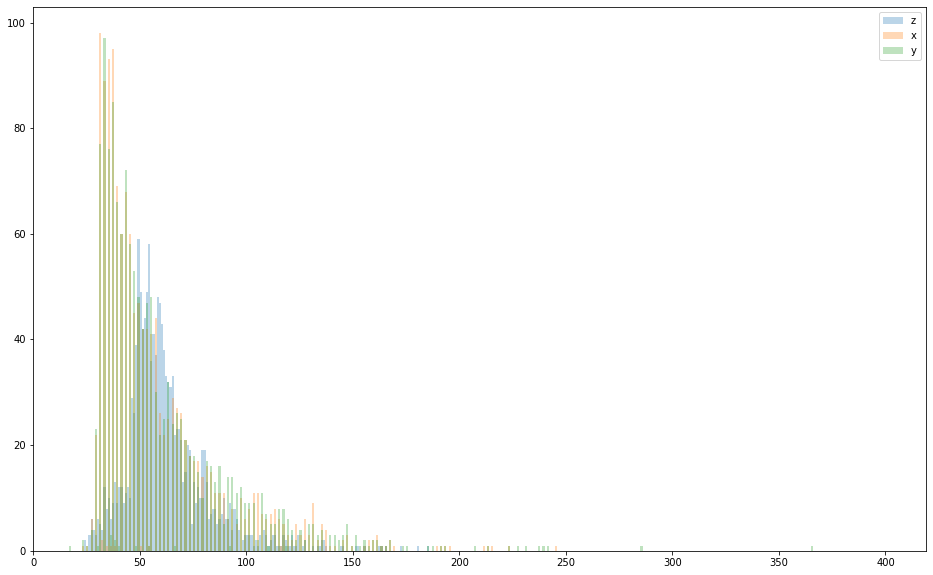

In [68]:
fig, ax = plt.subplots(figsize=(16, 10))
video_shapes = np.array(video_shapes)
bins = np.arange(0, 400, 1)
print("z", video_shapes[:, 0].min(), video_shapes[:, 0].max(), video_shapes[:, 0].mean())
print("x", video_shapes[:, 1].min(), video_shapes[:, 1].max(), video_shapes[:, 1].mean())
print("y", video_shapes[:, 2].min(), video_shapes[:, 2].max(), video_shapes[:, 2].mean())
plt.hist(video_shapes[:, 0], bins=bins, alpha=0.3, label="z")
plt.hist(video_shapes[:, 1], bins=bins, alpha=0.3, label="x")
plt.hist(video_shapes[:, 2], bins=bins, alpha=0.3, label="y")
plt.legend()
# plt.xlim(20, 100)
plt.xlim(0)
plt.show()

In [128]:
folder_nano_volumes = os.path.join(folder_data, "nano_volumes")
os.makedirs(folder_nano_volumes, exist_ok=True)

for name in tqdm(names_nano):
    filename = os.path.join(folder_nano, name)
    filename_out = os.path.join(folder_nano_volumes, name.split(".")[0] + ".npy")
    save_video_to_volume(filename, filename_out, (32, 32, 32))

/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [4]:
folder_test_numpy = "/media/igorkozlovskii/Elements/Projects/stall_catchers/test_numpy/"
os.makedirs(folder_test_numpy, exist_ok=True)

# for name in tqdm(names_test):
#     filename = os.path.join(folder_test, name)
#     filename_out = os.path.join(folder_test_numpy, name.split(".")[0] + ".npy")
#     save_video_to_volume(filename, filename_out, (32, 32, 32))

save_list(names_test, folder_test, folder_test_numpy, shape=(32, 32, 32), threads=7)

/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/igorkozlovskii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:168: DeprecationWarning: elementwise comparison fail

In [45]:
rect_list = []
for name in tqdm(names_nano):
    filename = os.path.join(folder_nano, name)
    video = read_video_frames(filename)
    rect = get_bounding_box(video[0])
    rect_list.append(rect)

25 373 68.31634819532908


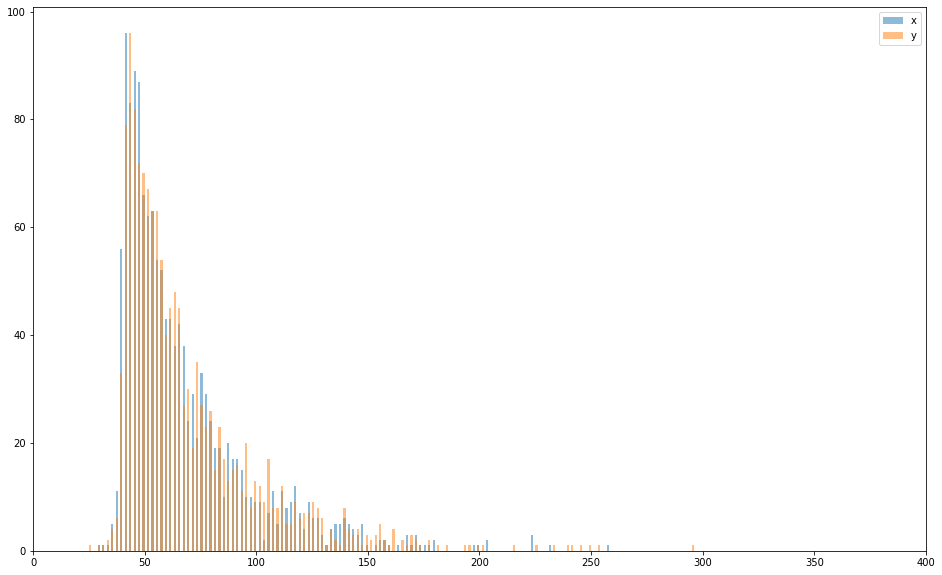

In [46]:
rect_sizes = [[r[2]-r[0], r[3]-r[1]] for r in rect_list]
rect_sizes = np.array(rect_sizes)

fig, ax = plt.subplots(figsize=(16, 10))
print(rect_sizes.min(), rect_sizes.max(), rect_sizes.mean())
bins = np.arange(rect_sizes.min(), rect_sizes.max(), 1)
plt.hist(rect_sizes[:, 0], bins=bins, alpha=0.5, label="x")
plt.hist(rect_sizes[:, 1], bins=bins, alpha=0.5, label="y")
plt.legend()
plt.xlim(0, 400)
plt.show()

In [35]:
filename = os.path.join(folder_nano, names_nano[np.argmax(rect_sizes[:, 0])])
print(filename)
Video(filename)

./data/./nano/223214.mp4


In [46]:
# print(video.shape, video.dtype)
# print(sys.getsizeof(video) / 1024 / 1024)
# print(1 * video.shape[0] * video.shape[1] * video.shape[2] * video.shape[3] / 1024 / 1024)

video_sizes = []
for name in tqdm(names_nano):
    filename = os.path.join(folder_nano, name)
    video = read_video_frames(filename)
    video_sizes.append(video.shape)

In [53]:
memory_size = sum(1 * v[0] * v[1] * v[2] * v[3] / 1024 / 1024 for v in video_sizes)
print(memory_size / 1024)

video_sizes_cropped = []
for i in range(len(video_sizes)):
    size = list(video_sizes[i])
    r = rect_sizes[i]
    size[1] = r[0]
    size[2] = r[1]
    video_sizes_cropped.append(size)
    
memory_size_cropped = sum(1 * v[0] * v[1] * v[2] * v[3] / 1024 / 1024 for v in video_sizes_cropped)
print(memory_size_cropped / 1024)

48.22664165496826
1.4930052626878023


In [54]:
data_train_metadata.head()

,filename,url,project_id,num_frames,crowd_score,tier1,micro,nano
0,100000.mp4,s3://drivendata-competition-clog-loss/train/10...,M,54,0.000000,True,False,False
1,100001.mp4,s3://drivendata-competition-clog-loss/train/10...,F,48,0.022769,False,False,False
2,100002.mp4,s3://drivendata-competition-clog-loss/train/10...,H,122,0.000000,True,False,False
3,100003.mp4,s3://drivendata-competition-clog-loss/train/10...,E,55,0.000000,True,False,False
4,100004.mp4,s3://drivendata-competition-clog-loss/train/10...,C,56,0.000000,True,False,False


In [10]:
data_nano_stall = data_train_metadata[
    (data_train_metadata.nano == True) & (data_train_metadata.crowd_score >= 0.75)]
names_nano_stall = data_nano_stall.filename.values.tolist()
print(len(names_nano_stall))

data_nano_stall = data_train_labels[
    (data_train_labels.filename.isin(names_nano)) & (data_train_labels.stalled == 1)]
print(len(data_nano_stall))
data_nano_flawing = data_train_labels[
    (data_train_labels.filename.isin(names_nano)) & (data_train_labels.stalled == 0)]
print(len(data_nano_flawing))

497
706
707


In [130]:
data_train_labels.head()

,filename,stalled
0,100000.mp4,0
1,100001.mp4,0
2,100002.mp4,0
3,100003.mp4,0
4,100004.mp4,0


In [57]:
data_train_metadata.loc[0, "url"]

's3://drivendata-competition-clog-loss/train/100000.mp4'

In [61]:
data_train_metadata.project_id.unique()
data_project_nano = data_train_metadata[
    (data_train_metadata.project_id == "M") & (data_train_metadata.filename.isin(names_nano))]
names_project_nano = data_project_nano.filename.values.tolist()

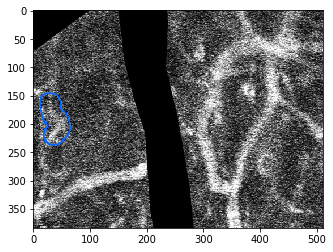

In [74]:
len(names_project_nano)
filename = os.path.join(folder_nano, names_project_nano[10])
show_frame(filename)